In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, recall_score, precision_score
import numpy as np
import statistics

In [20]:
def calculate_score_delta_t(data_frame, score_type, no_sensors, start_time, max_delta, step_size):
    """
    :param data_frame: Complete Dataframe
    :param no_sensors: Number of Sensors in Dataframe
    :param start_time: Start point. Value from time column
    :param max_delta: Number of samples. max_time = (no_samples * (time between two samples))
    :param step_size: It is the number of samples added to current time_delta to get next time_delta
    :return:
    """
    global column_names
    index_start = data_frame.index[data_frame['ID'] == float(start_time)].to_list()[0]
    subset = data_frame.loc[index_start:(index_start + max_delta), :]
    labels_pred = subset.iloc[:, (3 * no_sensors) + 1:(4 * no_sensors) + 1]
    labels_true = subset.iloc[:, (4 * no_sensors) + 1]

    number_evalutation_sequences = round(max_delta / step_size)
    result_score = np.zeros((number_evalutation_sequences, no_sensors + 1))

    for sensor in range(no_sensors):
        for iteration in range(1, number_evalutation_sequences - 1):
            anomaly_true = labels_true.iloc[0: (iteration * step_size)].values
            anomaly_pred = labels_pred.iloc[0: (iteration * step_size), sensor].values
            if score_type == "true_positive_rate":
                TP = confusion_matrix(anomaly_true, anomaly_pred)[1][1]
                FN = confusion_matrix(anomaly_true, anomaly_pred)[1][0]
                result = TP / (TP + FN)
                column_names = ["TPR_Sensor_" + str(i) for i in range(no_sensors)]
            else:
                result = 0
                column_names = ["error" for i in range(no_sensors)]

            result_score[iteration - 1, sensor] = result
            result_score[iteration - 1, no_sensors] = iteration * step_size

    score_df = pd.DataFrame(data=result_score, columns=column_names + ["delta_t"])
    return score_df

In [21]:
def calculate_score(data_frame, score_type, no_sensors):
    """
    :param data_frame: Complete Dataframe
    :param no_sensors: Number of Sensors in Dataframe
    :param start_time: Start point. Value from time column
    :param max_delta: Number of samples. max_time = (no_samples * (time between two samples))
    :param step_size: It is the number of samples added to current time_delta to get next time_delta
    :return:
    """
    labels_pred = data_frame.iloc[:, (3 * no_sensors) + 1:(4 * no_sensors) + 1]
    labels_true = data_frame.iloc[:, (4 * no_sensors) + 1].values
    
    result_score = np.zeros((no_sensors))

    for sensor in range(no_sensors):
        anomaly_pred = labels_pred.iloc[:, sensor].values
        if score_type == "f1_score":
            result = f1_score(labels_true, anomaly_pred, average="binary")
            index_names = ["f1 sensor_" + str(i) for i in range(no_sensors)]
        elif score_type == "precision_score":
            result = precision_score(labels_true, anomaly_pred, average="binary")
            index_names = ["precision sensor_" + str(i) for i in range(no_sensors)]
        elif score_type == "recall_score":
            result = recall_score(labels_true, anomaly_pred, average="binary")
            index_names = ["recall sensor_" + str(i) for i in range(no_sensors)]
        else:
            result = 0
            index_names = ["error" for i in range(no_sensors)]
            
        result_score[sensor] = result

    score_df = pd.Series(data=result_score, index=index_names)
    return score_df

In [22]:
def visualise_metric_per_sensor(results, title):
    fig, axes = plt.subplots(results.shape[1]-1, 1, figsize=(10,20),constrained_layout=False)
    ax = axes.ravel()
    t = results.loc[:,"delta_t"]
    columns = results.columns
    for i in range(results.shape[1]-1): 
        sns.lineplot(data=results, 
                     x=t, 
                     y=columns[i], 
                     ax=ax[i],
                     linewidth=1,
                     color="black")
        ax[i].set_xlabel("delta t [in samples]")
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title, fontsize=16)

In [23]:
def visualise_metric_machine(results, score_type, phase):
    t = results.loc[:,"delta_t"]
    complete_title = "CPPS Data - Beginning of Phase '{}''".format(phase)
    
    # Caluculate Metric for hole machine (sum over sensors and devide by no_sensors)
    labels = results.drop(columns="delta_t", axis=0)
    results_machine = labels.sum(axis=1) / results.shape[1]
    
    # Visualise Results
    sns.lineplot(x=t, 
                 y=results_machine, 
                 linewidth=1,
                 color="black")
    plt.xlabel("delta t [in samples]")
    plt.ylabel("{} over all dim".format(score_type))
    #plt.tight_layout()
    plt.title(complete_title, fontsize=16, y=1.12)

In [24]:
def vis_cumulative_detection(dataframe, no_features, first_feature, last_feature, location_line1, location_line2, subset):
    fig, axes = plt.subplots(subset, 1, figsize=(10,6), dpi=200)
    ax = axes.ravel()
    columns = dataframe.columns
    t = dataframe.iloc[:,0]
    for i in range(first_feature, last_feature):
        sns.lineplot(data=dataframe, 
                     x=t, 
                     y=dataframe.iloc[:, i+3*no_features].cumsum(),
                     ax=ax[i-first_feature],
                     color="blue",)
        ax[i-first_feature].axvline(location_line1, color="r", linestyle ="--", linewidth=2)
        ax[i-first_feature].axvline(location_line2, color="r", linestyle ="--", linewidth=2)
        ax[i-first_feature].text(7000, 14000, "Phase 1: No Error", fontsize=10)
        ax[i-first_feature].text(25000, 14000, "Phase 2: Small Error", fontsize=10)
        ax[i-first_feature].text(41000, 3000, "Phase 3: Large Error", fontsize=10)
        
        # Legend etc. 
        ax[i-1].set_xlabel("time [in s]")
        ax[i-1].set_ylabel("Cumulative sum")
        ax[i-1].set_title("Sensor No.{}".format(i))
        

In [25]:
def get_confusion_matrix_machine(data_frame, no_sensors, specific_sensor):
    
    tp = []
    fp = []
    tn = []
    fn = []
    for i in range(0,no_sensors):
        labels_pred = data_frame.iloc[:, (3 * no_sensors)+i+1].values
        labels_true = data_frame.iloc[:, (4 * no_sensors)+1 ].values
        
        tn_sensor, fp_sensor, fn_sensor, tp_sensor = confusion_matrix(labels_true, labels_pred).ravel()
        tp.append(tp_sensor)
        fp.append(fp_sensor)
        tn.append(tn_sensor)
        fn.append(fn_sensor)

    mean_tp = round(statistics.mean(tp),0)
    mean_fp = round(statistics.mean(fp),0)
    mean_tn = round(statistics.mean(tn),0)
    mean_fn = round(statistics.mean(fn),0)
    
    return mean_tp, mean_fp, mean_tn, mean_fn

# Evaluation of Euclidean Distance Metric
## Setup

In [61]:
start_phase_1 = 22475.0
start_phase_2 = 36415.0

In [67]:
all_data = pd.read_csv("../../files/classification/MSE/cpps_max_minus_60percent.csv", sep=";")
phase_0 = all_data.loc[all_data["ID"]<=start_phase_1]
phase_1 = all_data.loc[all_data["ID"]>=start_phase_1]
phase_2 = all_data.loc[all_data["ID"]>=start_phase_2]
phase_0_and_1 = all_data.loc[all_data["ID"]<start_phase_2]
phase_0_and_2 = pd.concat([phase_0, phase_2], ignore_index=True)

# Model Evaluation - Phases
## Phase 0 + Phase 1
### F1 Score 

In [68]:
score = calculate_score(phase_0_and_1, "f1_score", 10)
print(score.sum()/10)

0.5205096426627811


### Confusion Matrix

In [69]:
print("Positive --> Anomaly")
print("Negative --> Normal Behaviour")
print("--"*15)
mean_tp, mean_fp, mean_tn, mean_fn = get_confusion_matrix_machine(phase_0, 10, 0)
print("True negative: {}".format(mean_tn))
print("False positive: {}".format(mean_fp))
print("False negative: {}".format(mean_fn))
print("True positive: {}".format(mean_tp))

Positive --> Anomaly
Negative --> Normal Behaviour
------------------------------
True negative: 4940
False positive: 17513
False negative: 0
True positive: 0


## Sensetivity

In [70]:
print(mean_tn / (mean_tn + mean_fp))

0.2200151427426179


## Phase 0 + Phase 2
### F1 Score 

In [71]:
score = calculate_score(phase_0_and_2, "f1_score", 10)
print(score.sum()/10)

0.5622449731857515


## Confusion Matrix

In [53]:
print("Positive --> Anomaly")
print("Negative --> Normal Behaviour")
print("--"*15)
mean_tp, mean_fp, mean_tn, mean_fn = get_confusion_matrix_machine(phase_0, 10, 0)
print("Sensor No. {}:".format(1))
print("True negative: {}".format(mean_tn))
print("False positive: {}".format(mean_fp))
print("False negative: {}".format(mean_fn))
print("True positive: {}".format(mean_tp))

Positive --> Anomaly
Negative --> Normal Behaviour
------------------------------
Sensor No. 1:
True negative: 17645
False positive: 4808
False negative: 0
True positive: 0


## Sensetivity

In [54]:
print(mean_tn / (mean_tn + mean_fp))

0.7858638043913954


# Model Evaluation - Delta t
## Start Phase 1

In [34]:
delta_t_start_phase1 = calculate_score_delta_t(data_frame=all_data, 
                                               score_type="true_positive_rate", 
                                               no_sensors=10, 
                                               start_time=start_phase_1, 
                                               max_delta=50, 
                                               step_size=5)

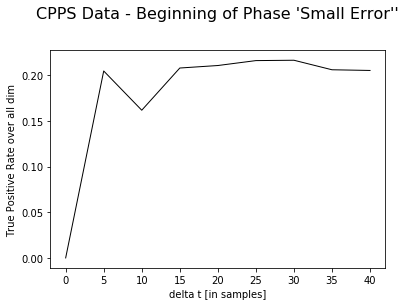

In [35]:
visualise_metric_machine(delta_t_start_phase1, "True Positive Rate", "Small Error")
#plt.savefig("./f1_score_cpps_data.png")
plt.show()

## Start Phase 2

In [36]:
delta_t_start_phase2 = calculate_score_delta_t(data_frame=all_data, 
                                               score_type="true_positive_rate", 
                                               no_sensors=10, 
                                               start_time=start_phase_2, 
                                               max_delta=50, 
                                               step_size=5)

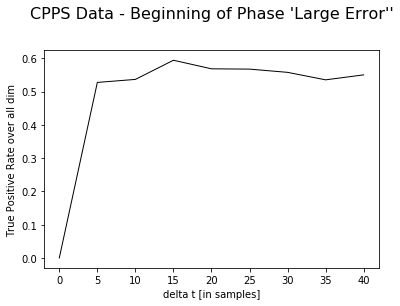

In [37]:
visualise_metric_machine(delta_t_start_phase2, "True Positive Rate", "Large Error")
#plt.savefig("./f1_score_cpps_data.png")
plt.show()

# Cumulative Sum of Anomaly, labeld by LSTM-Model

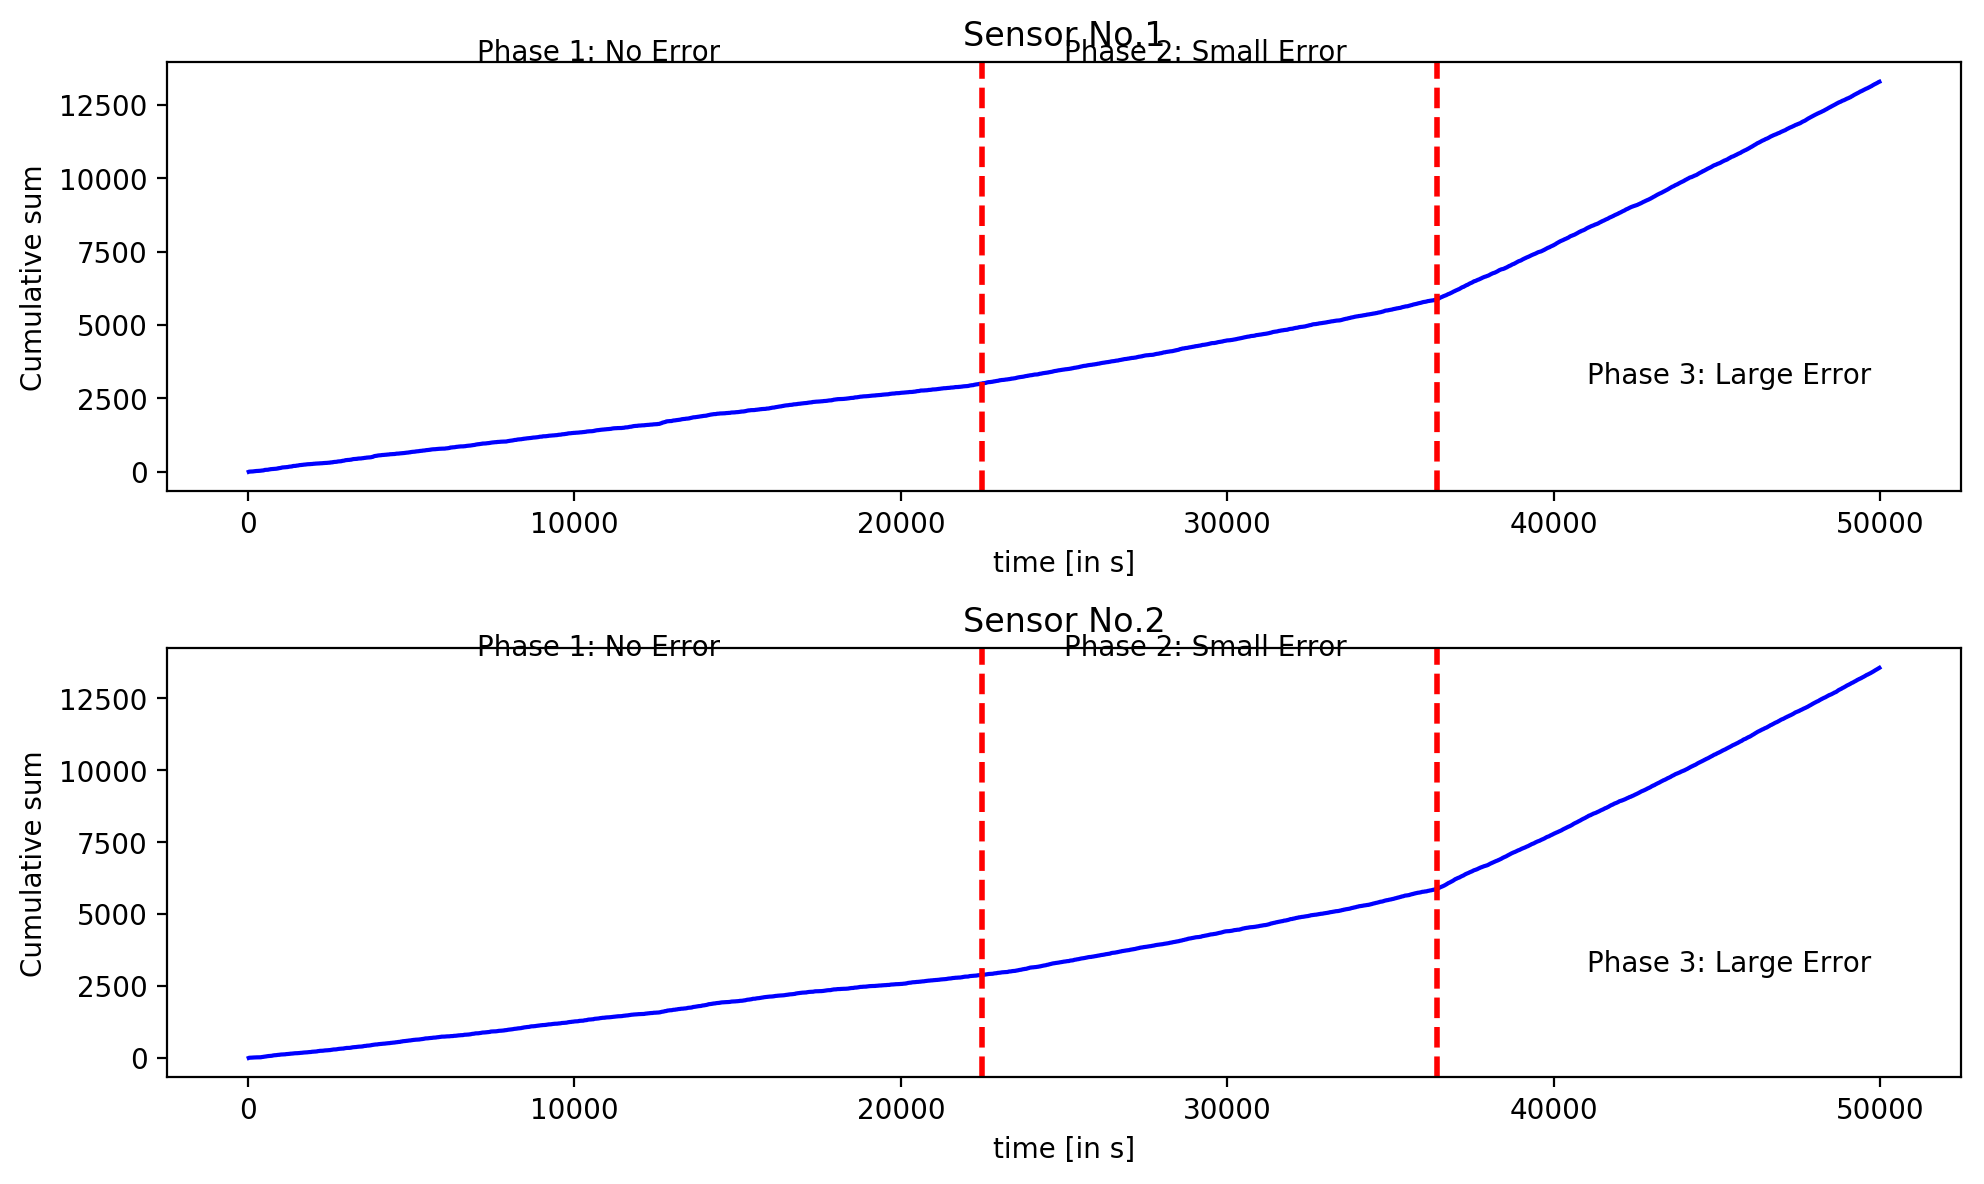

In [38]:
vis_cumulative_detection(all_data, 10, 1, 3, start_phase_1, start_phase_2, subset=2)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(pad=1)
plt.savefig("./pictures/cpps_cululative_sum.png")
plt.show()